# Ejemplo de clasificación 

El conjunto de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales ni más información general sobre los datos. Las características V1, V2, … V28 son los principales componentes obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La función 'Cantidad' es la cantidad de la transacción, esta función se puede utilizar para el aprendizaje sensible a los costos dependiente del ejemplo. Feature 'Class' es la variable de respuesta y toma valor 1 en caso de fraude y 0 en caso contrario.

## Importar librerias

In [1]:
#!pip install lazypredict

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Funciones auxiliares

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [5]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

In [6]:
dataset = pd.read_csv("creditcard.csv")

## División del conjunto de datos

In [7]:
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=validation_size, 
                                                   stratify=dataset["Class"],
                                                   random_state=seed)

## Preparación del conjunto de datos¶

In [8]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X)

DataFramePreparer()

## Escalado del conjunto de datos

In [10]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [11]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)

# Lazy predict para Clasificación

In [12]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_prep, X_test_prep, Y_train, Y_test)

 97%|█████████▋| 28/29 [15:25<00:38, 38.80s/it]

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339


100%|██████████| 29/29 [15:26<00:00, 31.96s/it]


In [13]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.98               0.93     0.93      0.99   
GaussianNB                         0.98               0.90     0.90      0.99   
KNeighborsClassifier               1.00               0.89     0.89      1.00   
XGBClassifier                      1.00               0.89     0.89      1.00   
RandomForestClassifier             1.00               0.89     0.89      1.00   
ExtraTreesClassifier               1.00               0.89     0.89      1.00   
NearestCentroid                    1.00               0.88     0.88      1.00   
DecisionTreeClassifier             1.00               0.88     0.88      1.00   
BaggingClassifier                  1.00               0.88     0.88      1.00   
LinearDiscriminantAnalysis         1.00               0.88     0.88      1.00   
PassiveAggressiveClassifier 

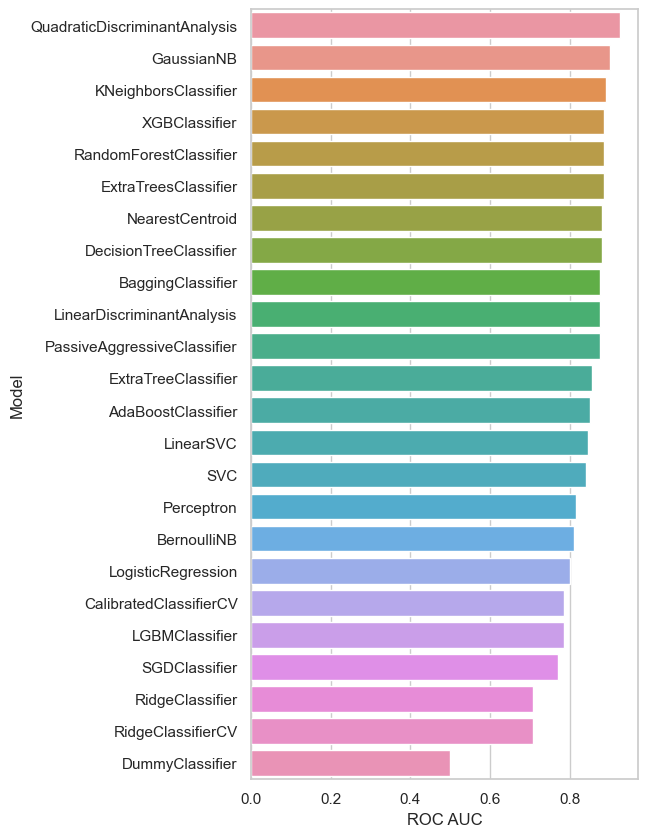

In [14]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="ROC AUC", data=predictions)

## Ejemplo de Regresión

### Tolerancia al riesgo de los inversores

Para predecir la tolerancia al riesgo de un individuo, utilizaremos los datos de la Encuesta de Finanzas del Consumidor (SCF), realizada por la Junta de la Reserva Federal. La encuesta incluye respuestas sobre la demografía de los hogares, el patrimonio neto y los activos financieros y no financieros para el mismo conjunto de personas en 2007 (antes de la crisis) y 2009 (poscrisis). Esto nos permite ver cómo cambió la asignación de cada hogar después de la crisis financiera mundial de 2008. La fuente de los datos: <https://www.federalreserve.gov/econres/scf_2009p.htm>

Las librerías utilizadas en este ejemplo son:

# Cargar datos

In [15]:
dataset = pd.read_excel('SCFP2009panel.xlsx')

## Preparamos la variable de predicción

In [16]:
# Promedio SP500 durante el 2007 y 2009
Average_SP500_2007=1478
Average_SP500_2009=948

# Tolerancia al riesgo en 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

# Tolerancia al riesgo en 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

Calculemos el cambio porcentual en la tolerancia al riesgo entre 2007 y 2009.

In [17]:
import copy

dataset2 = copy.deepcopy(dataset)
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

Comprobando las filas con valores nulos o nan y eliminándolas.

In [18]:
dataset2=dataset2.dropna(axis=0)
dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

En el siguiente paso, elegimos a los inversores inteligentes cuyo cambio en la tolerancia al riesgo entre 2007 y 2009 fue inferior al 10%. El propósito sería predecir la verdadera tolerancia al riesgo de un individuo dadas las características demográficas, financieras y de disposición a asumir riesgos.

In [19]:
dataset3 = copy.deepcopy(dataset2)  
dataset3 = dataset3[dataset3['PercentageChange']<=.1]
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

Eliminemos otras etiquetas que podrían no ser necesarias para la predicción.

In [20]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

## Selección de variables

### Eliminación de variables

Para filtrar aún más las variables, hacemos lo siguiente:

1. Consulte la descripción en el Diccionario de datos (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt) y mantengamos sólo las variables que sean intuitivas

La descripción es la siguiente:


- **AGE:** Hay 6 categorías de edad, donde 1 representa menos de 35 años y 6 representa más de 75 años.
- **EDUC:** Hay 4 categorías educativas, donde 1 representa sin escuela secundaria y 4 representa título universitario.
- **MARRIED:** Representa el estado civil. Hay dos categorías donde 1 representa casado y 2 representa soltero.
- **OCCU:** Representa la categoría de ocupación. 1 representa categoría gerencial y 4 representa desempleado.
- **KIDS:** Representa el número de niños.
- **NWCAT:** Representa la categoría de patrimonio neto. Hay 5 categorías, donde 1 representa un patrimonio neto inferior al percentil 25 y 5 representa un patrimonio neto superior al percentil 90.
- **INCCL:** Representa la categoría de ingresos. Hay 5 categorías, donde 1 ingreso menor a 10,000 y 5 representa un patrimonio neto mayor a 100,000
- **RISK:** Representa la disposición a asumir riesgos en una escala de 1 a 4, donde 1 representa el nivel más alto de disposición a asumir riesgos.

2. Mantener sólo los factores intuitivos a partir de 2007 únicamente y eliminar todas las características intermedias y características relacionadas con 2009, ya que las variables de 2007 son las únicas necesarias para predecir la tolerancia al riesgo.

In [21]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07',
              'NETWORTH07','TrueRiskTolerance']

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

In [22]:
dataset3.head()

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerance
60,77,2,1,0,3,31416.80,4,215248.97,0.20
425,55,4,1,1,2,2779588.16,2,49647586.87,0.64
1122,85,4,1,0,2,372741.71,4,58377675.05,0.59
1190,40,2,1,3,1,53248.82,3,268892.93,0.43
1228,70,2,1,0,2,37167.67,3,2015065.90,0.23


## División de los datos

In [23]:
# dividir el conjunto de datos de validación para el final
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
validation_size = 0.2
seed = 3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Lazy predict para la Regresión 

In [24]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:04<00:00,  9.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 8
[LightGBM] [Info] Start training from score 0.410121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [25]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.80       0.82  0.08        0.13
HistGradientBoostingRegressor                0.76       0.79  0.08        0.19
LGBMRegressor                                0.73       0.76  0.09        0.05
ExtraTreeRegressor                           0.73       0.76  0.09        0.02
RandomForestRegressor                        0.72       0.75  0.09        0.21
BaggingRegressor                             0.71       0.74  0.09        0.02
GradientBoostingRegressor                    0.71       0.74  0.09        0.11
XGBRegressor                                 0.66       0.70  0.10        0.09
AdaBoostRegressor                            0.45       0.51  0.13        0.03
DecisionTreeRegressor                        0.43       0.49  0.13        0.00
NuSVR                                        0.40   

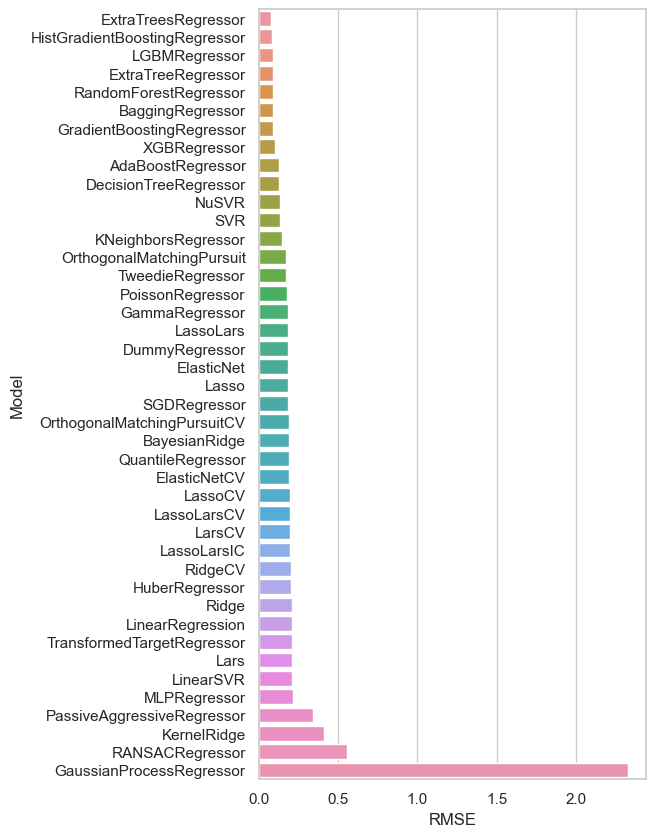

In [26]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="RMSE", data=predictions)